## 导入需要的库

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from segment_anything import sam_model_registry
from torchvision import transforms


## 掩码生成

In [2]:

# 路径设置
image_dir = '/home/a6/vis/LDS/SAM/datasets/images'
json_dir = '/home/a6/vis/LDS/SAM/datasets/json'
output_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
os.makedirs(output_dir, exist_ok=True)

# 遍历所有JSON文件
for json_file in os.listdir(json_dir):
    if json_file.endswith('.json'):
        # 获取对应的PNG文件路径
        base_name = os.path.splitext(json_file)[0]
        png_file = f"{base_name}.png"
        image_path = os.path.join(image_dir, png_file)
        json_path = os.path.join(json_dir, json_file)

        # 读取图像和JSON文件
        image = Image.open(image_path)
        width, height = image.size
        mask = Image.new('L', (width, height), 0)  # 创建掩码图像，背景为0

        # 解析JSON文件
        with open(json_path, 'r') as f:
            data = json.load(f)
            # 先处理非背景标签
            for shape in data['shapes']:
                label = shape['label'].lower()
                if 'background' not in label:  # 处理非背景标签
                    polygon = [(int(point[0]), int(point[1])) for point in shape['points']]
                    if label == 'pore':  # 处理孔隙标签
                        ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)  # 标记为1

            # 处理背景标签
            for shape in data['shapes']:
                label = shape['label'].lower()
                if 'background' in label:  # 处理背景标签
                    polygon = [(int(point[0]), int(point[1])) for point in shape['points']]
                    ImageDraw.Draw(mask).polygon(polygon, outline=0, fill=0)  # 标记为0

        # 保存掩码图像
        mask.save(os.path.join(output_dir, f"{base_name}_mask.png"))

## 微调SAM的图像编码器
### 1. 定义SAM模型

In [3]:
model_type = 'vit_l'
checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_l_0b3195.pth'
device = 'cuda:0'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)

/home/a6/anaconda3/envs/LDS/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

### 2. 数据加载

In [4]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segment_anything import sam_model_registry

# 读取训练集和验证集列表
def read_split_files(file_path):
    with open(file_path, 'r') as f:
        file_names = f.read().strip().split('\n')
    return file_names

# 数据集加载
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, sam_model, file_list, mask_size=(256, 256), device='cpu'):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.sam_model = sam_model
        self.mask_size = mask_size
        self.device = device
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') and f.replace('.png', '') in file_list]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 读取图像
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)

        # 读取掩码
        mask_file = image_file.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, self.mask_size, interpolation=cv2.INTER_NEAREST)

        # 转换为torch tensor
        input_image_torch = torch.as_tensor(image, dtype=torch.float32).to(self.device)
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()  # [C, H, W]

        # SAM模型的预处理步骤
        input_image = self.sam_model.preprocess(input_image_torch.to(self.device))

        # 将掩码转换为torch tensor
        mask = torch.as_tensor(mask, dtype=torch.long).to(self.device)  # 掩码为单通道

        return input_image, mask

# 创建训练集和验证集的数据集实例
# 设置路径
image_dir = '/home/a6/vis/LDS/SAM/datasets/images'
mask_dir = '/home/a6/vis/LDS/SAM/datasets/masks'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取文件名列表
train_files = read_split_files('/home/a6/vis/LDS/SAM/datasets/train.txt')
val_files = read_split_files('/home/a6/vis/LDS/SAM/datasets/val.txt')

# 假设sam_model是你定义的模型实例，并且已经包含preprocess方法
sam_model = sam_model_registry['vit_l'](checkpoint='/home/a6/vis/LDS/SAM/sam_model.pth')
sam_model.to(device)

# 创建训练集和验证集的数据集和数据加载器
train_dataset = SegmentationDataset(image_dir, mask_dir, sam_model, train_files, device=device)
val_dataset = SegmentationDataset(image_dir, mask_dir, sam_model, val_files, device=device)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# 测试数据加载器
for i, (images, masks) in enumerate(train_loader):
    print(f'Train Batch {i}:')
    print(f'Images shape: {images.shape}')  # 应为 [B, C, H, W]
    print(f'Masks shape: {masks.shape}')    # 应为 [B, H, W]
    print(f'Mask unique values: {torch.unique(masks)}')  # 输出掩码中的唯一值
    break

for i, (images, masks) in enumerate(val_loader):
    print(f'Val Batch {i}:')
    print(f'Images shape: {images.shape}')  # 应为 [B, C, H, W]
    print(f'Masks shape: {masks.shape}')    # 应为 [B, H, W]
    print(f'Mask unique values: {torch.unique(masks)}')  # 输出掩码中的唯一值
    break


Train Batch 0:
Images shape: torch.Size([1, 3, 1024, 1024])
Masks shape: torch.Size([1, 256, 256])
Mask unique values: tensor([0, 1], device='cuda:0')
Val Batch 0:
Images shape: torch.Size([1, 3, 1024, 1024])
Masks shape: torch.Size([1, 256, 256])
Mask unique values: tensor([0, 1], device='cuda:0')


In [5]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from tqdm import tqdm

# # 定义损失函数
# loss_fn = nn.MSELoss()
# # 训练循环
# sam_model.train()
# num_epochs = 50

# # 优化图像编码器
# # optimizer = torch.optim.Adam(sam_model.image_encoder.parameters(), lr=1e-4)
# # 定义优化器，仅优化最后一层
# optimizer = torch.optim.Adam(sam_model.image_encoder.neck.parameters(), lr=1e-4)

# best_val_loss = float('inf')
# best_epoch = 0
# checkpoint_path = '/home/a6/vis/LDS/SAM/logs/best_model.pth'  # 替换为实际保存路径

# for epoch in range(num_epochs):
#     sam_model.train()  # 切换模型到训练模式
#     total_loss = 0  # 累加每个batch的损失
#     num_batches = 0

#     # 训练阶段
#     for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]"):
#         images, masks = images.to(device), masks.to(device)

#         # 前向传播：获取图像嵌入
#         image_embedding = sam_model.image_encoder(images)  # B 256 64 64

#         # 上采样到 (B, 256, 256, 256)
#         upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)

#         # 求通道均值 (B, 1, 256, 256)
#         mean_embedding = upsampled_embedding.mean(dim=1)
        
#         # 计算损失
#         loss = loss_fn(mean_embedding, masks.float())

#         # 反向传播和优化
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # 累加损失
#         total_loss += loss.item()
#         num_batches += 1

#     # 计算平均损失
#     avg_train_loss = total_loss / num_batches

#     # 验证阶段
#     sam_model.eval()  # 切换模型到评估模式
#     val_loss = 0
#     num_val_batches = 0

#     with torch.no_grad():  # 关闭梯度计算
#         for images, masks in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
#             images, masks = images.to(device), masks.to(device)

#             # 前向传播：获取图像嵌入
#             image_embedding = sam_model.image_encoder(images)  # B 256 64 64

#             # 上采样到 (B, 256, 256, 256)
#             upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)

#             # 求通道均值 (B, 1, 256, 256)
#             mean_embedding = upsampled_embedding.mean(dim=1)  # 去掉 keepdim=True

#             # 计算损失
#             loss = loss_fn(mean_embedding, masks.float())

#             # 累加损失
#             val_loss += loss.item()
#             num_val_batches += 1

#     avg_val_loss = val_loss / num_val_batches

#     # 输出训练和验证损失
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}, Average Val Loss: {avg_val_loss:.4f}")

#     # 保存验证集上指标最好的模型
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_epoch = epoch + 1
#         torch.save(sam_model.state_dict(), checkpoint_path)
#         print(f"Best model saved at epoch {best_epoch} with val loss {best_val_loss:.4f}")

# print("训练完成")


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# 定义类别特征向量
num_classes = 2
feature_dim = 256
class_centers = nn.Embedding(num_classes, feature_dim).to(device)

# 使用正交初始化使类别中心向量彼此远离
def orthogonal_initialization(embedding):
    weight = embedding.weight.data
    nn.init.orthogonal_(weight)

orthogonal_initialization(class_centers)

# 确保类别中心向量在训练过程中更新
class_centers.weight.requires_grad = True

# 定义欧几里得距离损失函数
def euclidean_distance_loss(features, centers, labels):
    # 获取每个像素对应的类别中心向量
    centers_batch = centers(labels)
    # 计算每个像素特征向量与对应类别中心向量的欧几里得距离
    distance = torch.norm(features - centers_batch, p=2, dim=1)
    return distance.mean()

# 定义损失函数
loss_fn = euclidean_distance_loss

# 训练循环
sam_model.train()
num_epochs = 50

# 优化图像编码器的最后一层和类别中心向量
optimizer = torch.optim.Adam(list(sam_model.image_encoder.neck.parameters()) + list(class_centers.parameters()), lr=1e-4)

best_val_loss = float('inf')
best_epoch = 0
checkpoint_path = '/home/a6/vis/LDS/SAM/logs/best_model.pth'  # 替换为实际保存路径

for epoch in range(num_epochs):
    sam_model.train()  # 切换模型到训练模式
    total_loss = 0  # 累加每个batch的损失
    num_batches = 0

    # 训练阶段
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]"):
        images, masks = images.to(device), masks.to(device)

        # 前向传播：获取图像嵌入
        image_embedding = sam_model.image_encoder(images)  # B 256 64 64

        # 上采样到 (B, 256, 256, 256)
        upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)

        # 将特征图展平
        mean_embedding = upsampled_embedding.permute(0, 2, 3, 1).contiguous().view(-1, feature_dim)
        # 将掩码展平
        masks_flat = masks.view(-1)

        # 计算欧几里得距离损失
        loss = loss_fn(mean_embedding, class_centers, masks_flat)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累加损失
        total_loss += loss.item()
        num_batches += 1

    # 计算平均损失
    avg_train_loss = total_loss / num_batches

    # 验证阶段
    sam_model.eval()  # 切换模型到评估模式
    val_loss = 0
    num_val_batches = 0

    with torch.no_grad():  # 关闭梯度计算
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Validation]"):
            images, masks = images.to(device), masks.to(device)

            # 前向传播：获取图像嵌入
            image_embedding = sam_model.image_encoder(images)  # B 256 64 64

            # 上采样到 (B, 256, 256, 256)
            upsampled_embedding = F.interpolate(image_embedding, size=(256, 256), mode='bilinear', align_corners=False)

            # 将特征图展平
            mean_embedding = upsampled_embedding.permute(0, 2, 3, 1).contiguous().view(-1, feature_dim)
            # 将掩码展平
            masks_flat = masks.view(-1)

            # 计算欧几里得距离损失
            loss = loss_fn(mean_embedding, class_centers, masks_flat)

            # 累加损失
            val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = val_loss / num_val_batches

    # 输出训练和验证损失
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}, Average Val Loss: {avg_val_loss:.4f}")

    # 保存验证集上指标最好的模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        torch.save(sam_model.state_dict(), checkpoint_path)
        print(f"Best model saved at epoch {best_epoch} with val loss {best_val_loss:.4f}")

print("训练完成")


Epoch 1/50 [Train]:   0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.67it/s]


Epoch [1/50], Average Train Loss: 1.1874, Average Val Loss: 0.5842
Best model saved at epoch 1 with val loss 0.5842


Epoch 2/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch [2/50], Average Train Loss: 0.2072, Average Val Loss: 0.2005
Best model saved at epoch 2 with val loss 0.2005


Epoch 3/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s]


Epoch [3/50], Average Train Loss: 0.1092, Average Val Loss: 0.1527
Best model saved at epoch 3 with val loss 0.1527


Epoch 4/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch [4/50], Average Train Loss: 0.0825, Average Val Loss: 0.1230
Best model saved at epoch 4 with val loss 0.1230


Epoch 5/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.66it/s]


Epoch [5/50], Average Train Loss: 0.0673, Average Val Loss: 0.1033
Best model saved at epoch 5 with val loss 0.1033


Epoch 6/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch [6/50], Average Train Loss: 0.0576, Average Val Loss: 0.0931
Best model saved at epoch 6 with val loss 0.0931


Epoch 7/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch [7/50], Average Train Loss: 0.0500, Average Val Loss: 0.0775
Best model saved at epoch 7 with val loss 0.0775


Epoch 8/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.64it/s]


Epoch [8/50], Average Train Loss: 0.0440, Average Val Loss: 0.0684
Best model saved at epoch 8 with val loss 0.0684


Epoch 9/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.65it/s]


Epoch [9/50], Average Train Loss: 0.0388, Average Val Loss: 0.0576
Best model saved at epoch 9 with val loss 0.0576


Epoch 10/50 [Validation]: 100%|██████████| 31/31 [00:04<00:00,  6.63it/s]


Epoch [10/50], Average Train Loss: 0.0351, Average Val Loss: 0.0524
Best model saved at epoch 10 with val loss 0.0524


Epoch 11/50 [Train]:  17%|█▋        | 29/167 [00:11<00:52,  2.61it/s]


KeyboardInterrupt: 

/home/a6/anaconda3/envs/LDS/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Mean Embedding Max Value: -0.00489763030782342
Mean Embedding Min Value: -0.008238483220338821


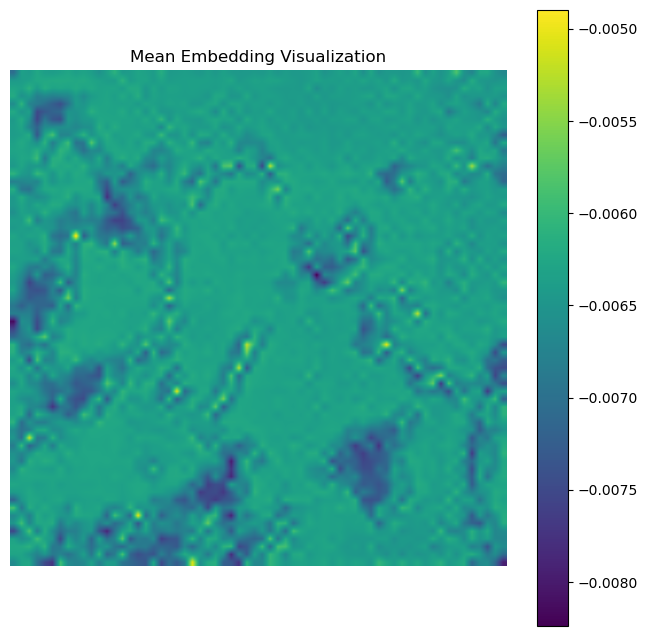

In [1]:
import numpy as np
import torch
import json
import os
import matplotlib.pyplot as plt
import cv2
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from segment_anything import sam_model_registry
import torch.nn.functional as F

# 设置参数
model_type = 'vit_l'
checkpoint = '/home/a6/vis/LDS/SAM/logs/best_model.pth'
device = 'cuda:0'
image_path = '/home/a6/vis/LDS/SAM/datasets/images/S1-B6m2-.png'  # 替换为你的图像路径

# 加载模型
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.eval()  # 切换模型到评估模式

# 加载和预处理图像
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)

# 转换为 torch 张量并预处理
input_image_torch = torch.as_tensor(image, dtype=torch.float32).to(device)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()  # [C, H, W]
transformed_image = input_image_torch[None, :, :, :]  # 增加 batch 维度
input_image = sam_model.preprocess(transformed_image)

# 获取图像嵌入
with torch.no_grad():  # 关闭梯度计算
    image_embedding = sam_model.image_encoder(input_image)

# 上采样到 (1, 256, 256)
upsampled_embedding = F.interpolate(image_embedding, size=(1024, 1024), mode='bilinear', align_corners=False)
mean_embedding = upsampled_embedding.mean(dim=1, keepdim=True)  # 求通道均值

# 将嵌入数据移到CPU以进行可视化
mean_embedding_cpu = mean_embedding.squeeze().cpu().numpy()  # 移除 batch 维度并转换为 numpy
# 获取 mean_embedding_cpu 的最大值和最小值
max_value = mean_embedding_cpu.max()
min_value = mean_embedding_cpu.min()

# 输出最大值和最小值
print(f"Mean Embedding Max Value: {max_value}")
print(f"Mean Embedding Min Value: {min_value}")

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(mean_embedding_cpu, cmap='viridis')
plt.colorbar()
plt.title('Mean Embedding Visualization')
plt.axis('off')
plt.show()
